In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [6]:
#read the data and split it into train test validate
data = pd.read_csv("combined_df.csv")
data['dataset'].fillna('validation')
train_data = data[data['dataset'] == 'train']
validate_data = data[data['dataset'] == 'validation']
test_data = data[data['dataset'] == 'test']

In [9]:
#test_data.head()

In [13]:
#split into X and Y serately , impute the data and create a new actor directro combo field
X = train_data
Y = train_data['success_level']
Y_test = test_data['success_level']
Y_val = validate_data['success_level']
X['actor1Name'] = X['actor1Name'].fillna('Unknown')
X['dir1Name'] = X['dir1Name'].fillna('Unknown')
X['actordircombo'] = X['actor1Name'] + ' ' + X['dir1Name']
X['budget'] = X['budget'].fillna(X['budget'].mean())
X['runtime'] = X['budget'].fillna(X['runtime'].mean())
validate_data['actor1Name'] = validate_data['actor1Name'].fillna('Unknown')
validate_data['dir1Name'] = validate_data['dir1Name'].fillna('Unknown')
validate_data['actordircombo'] = validate_data['actor1Name'] + ' ' + validate_data['dir1Name']
validate_data['budget'] =validate_data['budget'].fillna(validate_data['budget'].mean())
validate_data['runtime'] =validate_data['runtime'].fillna(validate_data['runtime'].mean())
test_data['actor1Name'] = test_data['actor1Name'].fillna('Unknown')
test_data['dir1Name'] = test_data['dir1Name'].fillna('Unknown')
test_data['actordircombo'] = test_data['actor1Name'] + ' ' + test_data['dir1Name']
test_data['budget'] =test_data['budget'].fillna(test_data['budget'].mean())
validate_data['runtime'] =validate_data['runtime'].fillna(validate_data['runtime'].mean())

In [17]:
#vectroize the data to perform TF idf encosding and combined TF idf encoded text fields with numeirc fields 
X['combined'] = X['actor1Name'] + ' ' + X['dir1Name'] + ' ' + X['actordircombo']

# Fit the vectorizer on the combined training data
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X['combined'])

# Convert to dense format for training
X_train_tfidf_dense = X_train_tfidf.toarray()
X_train_with_budget = np.hstack([X_train_tfidf_dense,\
                                 X['budget'].values.reshape(-1, 1),\
                                 X['adult'].values.reshape(-1, 1),\
                                 X['dir_act_blockbuster'].values.reshape(-1, 1),\
                                 X['dir_act_success'].values.reshape(-1, 1),\
                                 X['dir_act_flop'].values.reshape(-1, 1)\
                                ])

# Train your model
Y_numeric = LabelEncoder().fit_transform(Y)  # Assuming Y is the target variable
xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')
xgb.fit(X_train_with_budget, Y_numeric)

Y_val_numeric = LabelEncoder().fit_transform(Y_val)  # Assuming Y is the target variable
validate_data['combined'] = validate_data['actor1Name'] + ' ' + validate_data['dir1Name'] + ' ' + validate_data['actordircombo']
validate_tfidf = vectorizer.transform(validate_data['combined'])
validate_tfidf_dense = validate_tfidf.toarray()
validate_with_budget = np.hstack([validate_tfidf_dense, \
                                  validate_data['budget'].values.reshape(-1, 1),\
                                  validate_data['adult'].values.reshape(-1, 1),\
                                  validate_data['dir_act_blockbuster'].values.reshape(-1, 1),\
                                  validate_data['dir_act_success'].values.reshape(-1, 1),\
                                  validate_data['dir_act_flop'].values.reshape(-1, 1)\
                                  ])
# Prepare the test data
test_data['combined'] = test_data['actor1Name'] + ' ' + test_data['dir1Name'] + ' ' + test_data['actordircombo']

# Fill NaN values in the test data
test_data['actor1Name'] = test_data['actor1Name'].fillna('Unknown')
test_data['dir1Name'] = test_data['dir1Name'].fillna('Unknown')
test_data['actordircombo'] = test_data['actordircombo'].fillna('Unknown')

# Transform the test data using the fitted vectorizer (not fit_transform, which would change the vocabulary)
X_test_tfidf = vectorizer.transform(test_data['combined'])

# Convert to dense format for prediction
X_test_tfidf_dense = X_test_tfidf.toarray()
test_with_budget = np.hstack([X_test_tfidf_dense, \
                              test_data['budget'].values.reshape(-1, 1),\
                              test_data['adult'].values.reshape(-1, 1),\
                              test_data['dir_act_blockbuster'].values.reshape(-1, 1),\
                              test_data['dir_act_success'].values.reshape(-1, 1),\
                              test_data['dir_act_flop'].values.reshape(-1, 1)\
                             ])
# Ensure that the test features match the training features in number and order
assert X_test_tfidf_dense.shape[1] == X_train_tfidf_dense.shape[1], \
    f"Feature mismatch: train has {X_train_tfidf_dense.shape[1]} features, test has {X_test_tfidf_dense.shape[1]} features."

# Predict on the test set
#y_test_pred = xgb.predict(test_with_budget)

# # Convert the actual test labels to numeric
#Y_test_numeric = LabelEncoder().fit_transform(Y_test)  # Assuming Y_test is the target variable for the test set

# # Calculate accuracy
#test_accuracy = accuracy_score(y_test_pred, Y_test_numeric)

#print(f"Test accuracy: {test_accuracy * 100:.2f}%")

In [21]:
#hypertune the paramters 
#have used grid search for most but at times used RandomziedSearch to quicken the process since Grid Search took a long time 
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Perform grid search to tune hyperparameters
grid_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(validate_with_budget, Y_val_numeric)

# Print best hyperparameters found
print("Best hyperparameters found: ", grid_search.best_params_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Predict on the validation data
y_validate_pred = best_model.predict(validate_with_budget)

# Calculate validation accuracy
validate_accuracy = accuracy_score(y_validate_pred, Y_val_numeric)
print(f"Validation accuracy: {validate_accuracy * 100:.2f}%")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters found:  {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Validation accuracy: 58.90%


In [19]:
# y_validate_pred = best_model.predict(validate_with_budget)

# # Calculate validation accuracy
# validate_accuracy = accuracy_score(y_validate_pred, Y_val_numeric)
# print(f"Validation accuracy: {validate_accuracy * 100:.2f}%")

NameError: name 'best_model' is not defined

In [22]:
y_test_predict = best_model.predict(test_with_budget)
test_accuracy = accuracy_score(y_test_predict, Y_test_numeric)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 45.98%


In [87]:
#get the encodig value for the Y 
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
encoder = LabelEncoder()

# Fit the encoder on Y_test (or whatever labels you have)
encoder.fit(Y_test)

# Now you can access encoder.classes_
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(label_mapping)

{'Blockbuster': 0, 'Flop': 1, 'Success': 2}


In [23]:
Plot confusion amtrix
import seaborn as sns
cm = confusion_matrix(Y_test_numeric, y_test_predict, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Blockbuster', 'Flop', 'Success'], yticklabels=['Blockbuster', 'Flop', 'Success'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

SyntaxError: invalid syntax (2939735137.py, line 1)

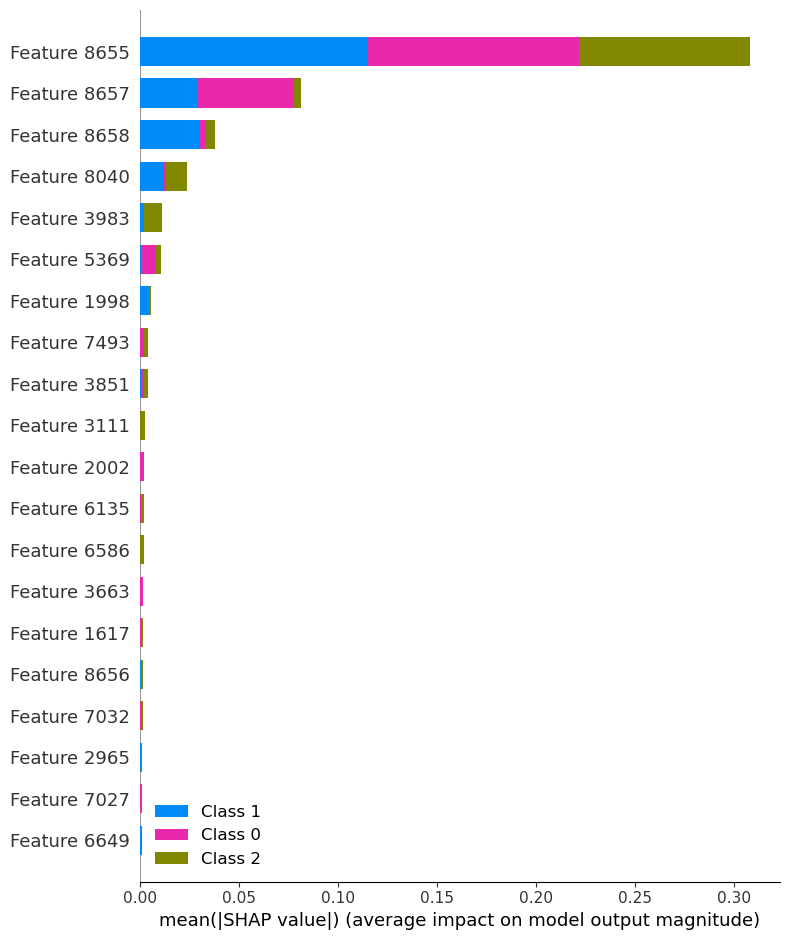

In [91]:
#!pip install shap
#get feature importance 
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(test_with_budget)  # Use test data
shap.summary_plot(shap_values, test_with_budget)

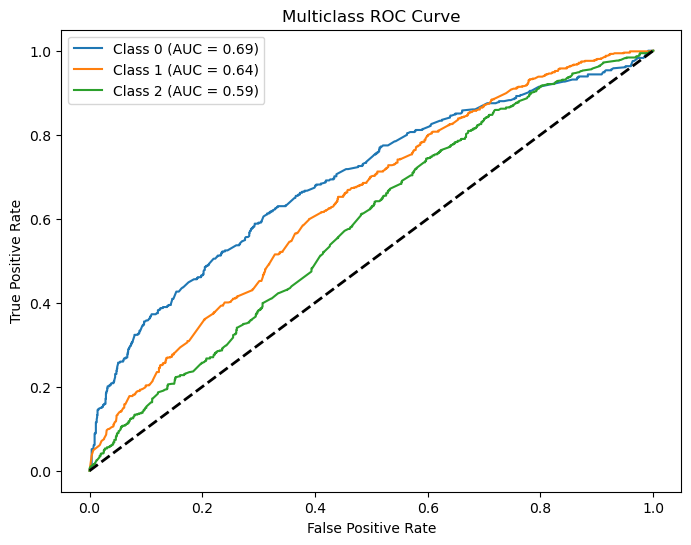

In [122]:
#Plot the ROC curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
n_classes = len(set(Y_test_numeric))  # Number of classes
y_test_bin = label_binarize(Y_test_numeric, classes=range(n_classes))
y_probs = best_model.predict_proba(test_with_budget)  # Get probability scores

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()
plt.show()

In [31]:
#get the F1 score for the matrix
from sklearn.metrics import f1_score
f1_per_class = f1_score(Y_test_numeric, y_test_predict, average=None)
print("F1 Score per class:", f1_per_class)

#from sklearn.metrics import f1_score

f1_micro = f1_score(Y_test_numeric, y_test_predict, average='micro')
print("Micro F1 Score:", f1_micro)

F1 Score per class: [0.35472973 0.38843722 0.53790814]
Micro F1 Score: 0.4597832287507131


In [29]:
#get the Blockbuster analytics for top 5 actor 
data['actor_BB_pct'] = (data['actor_blockbuster']*100)/ data['actor_total']
actor = data[['actor1Name','actor_BB_pct','actor_total']].drop_duplicates()
actor = actor[actor['actor_total']>1]
sorted_actor = actor.sort_values(by=['actor_BB_pct','actor_total'], ascending=False)

# Print movie names in sorted order
print(sorted_actor)

                actor1Name  actor_BB_pct  actor_total
1774               Jing Wu         100.0          5.0
2505        Rowan Atkinson         100.0          5.0
4789      Vijay Sethupathi         100.0          3.0
686          Paulo Gustavo         100.0          2.0
1019    Heather Langenkamp         100.0          2.0
...                    ...           ...          ...
11111      Jonathan Tucker           NaN          2.0
11180          Ann-Margret           NaN          2.0
11346  Christina Applegate           NaN          2.0
11477              Om Puri           NaN          2.0
11490           Eva Mendes           NaN          2.0

[1781 rows x 3 columns]


In [27]:
#get the Blockbuster analytics for top 5 director 
data['dir_BB_pct'] = (data['dir_blockbuster']*100)/ data['dir_total']
actor = data[['dir1Name','dir_BB_pct','dir_total']].drop_duplicates()
actor = actor[actor['dir_total']>1]
sorted_actor = actor.sort_values(by=['dir_BB_pct','dir_total'], ascending=False)

# Print movie names in sorted order
print(sorted_actor)

             dir1Name  dir_BB_pct  dir_total
2140      David Yates       100.0        7.0
2801      J.J. Abrams       100.0        6.0
2509     Nancy Meyers       100.0        5.0
2832  Carlos Saldanha       100.0        5.0
15       Rob Marshall       100.0        4.0
...               ...         ...        ...
8496     Jane Campion         NaN        2.0
8791   Lamont Johnson         NaN        2.0
8923     Bruno Dumont         NaN        2.0
9038   Masaaki Tezuka         NaN        2.0
9085     Alex Garland         NaN        2.0

[1271 rows x 3 columns]


In [25]:
#get the Blockbuster analytics for top 5 actor director combo
data['act_dir_BB_pct'] = (data['dir_act_blockbuster']*100)/ data['dir_act_total']
actor = data[['actor1Name','dir1Name','act_dir_BB_pct','dir_act_total']].drop_duplicates()
actor = actor[actor['dir_act_total']>1]
sorted_actor = actor.sort_values(by=['act_dir_BB_pct','dir_act_total'], ascending=False)

# Print movie names in sorted order
print(sorted_actor)

            actor1Name             dir1Name  act_dir_BB_pct  dir_act_total
592       Adam Sandler         Dennis Dugan           100.0            6.0
2581     Tobey Maguire            Sam Raimi           100.0            6.0
3900         Paul Rudd          Peyton Reed           100.0            6.0
491   Johnny Knoxville        Jeff Tremaine           100.0            5.0
3484    Michael J. Fox      Robert Zemeckis           100.0            5.0
...                ...                  ...             ...            ...
9811         Adam West  Leslie H. Martinson             NaN            2.0
9819   Deborah Winters            Tom Daley             NaN            2.0
9846    Hiro Mizushima      Hidenori Ishida             NaN            2.0
9918       Xavier Gonz          Xavier Gonz             NaN            2.0
9977  Samantha Heights                  NaN             NaN            2.0

[843 rows x 4 columns]


In [ ]:
#BB, FLop , Success